# Graph models

This notebook demonstrates the application of Graph Neural Networks (GNNs) for predicting mortgage defaults using loan-level data from Freddie Mac. The central methodology involves transforming structured, tabular loan data into a graph structure to capture and leverage the relationships between individual loans. Nodes in the graph represent mortgages, while edges are established based on shared attributes, specifically the geographical area (AREA) of the property and the loan provider. This relational structure allows the GNN to learn from both the intrinsic features of each loan and the contextual information of its neighbors.

The process begins with data loading and preprocessing, followed by the explicit construction of a graph where node features are derived from the loan's characteristics (e.g., credit score, DTI ratio) and augmented with a graph-based feature, the node's degree. The notebook then implements and compares the performance of three prominent GNN architectures—Graph Convolutional Network (GCN), Graph Attention Network (GAT), and GraphSAGE—on the binary classification task of default prediction. The models are trained in a transductive setting, utilizing node-level splits for training, validation, and testing. The chapter concludes by evaluating the models using standard metrics like the Area Under the ROC Curve (AUC) and accuracy, presenting a comprehensive workflow for applying GNNs in a financial risk context.

In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import PIL
import os
import random
import pickle

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import OneHotEncoder, StandardScaler

%matplotlib inline
import networkx as nx
from tqdm import tqdm
# Import Pytorch lybraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

# For validation
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_auc_score,roc_curve, auc,accuracy_score

import torch_geometric
from torch_geometric.utils import from_networkx, assortativity, degree, homophily
from torch_geometric.data import Data
from torch_geometric.transforms import RandomNodeSplit
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, SAGEConv



In [ ]:
!gdown --id '1YadoR0hR_uZJe5XyGhh0PUwjqfkeJu7k'

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1YadoR0hR_uZJe5XyGhh0PUwjqfkeJu7k
To: /content/graph_df.csv
100% 11.1M/11.1M [00:00<00:00, 43.5MB/s]


In [ ]:
merged_df=pd.read_csv("/content/graph_df.csv")
merged_df.head()

,CREDIT_SCORE,CLTV,DTI_RATIO,ORIGINAL_UPB,CURRENT_INTEREST_RATE,ESTIMATED_LOAN_TO_VALUE,FIRST_TIME_HOMEBUYER_N,FIRST_TIME_HOMEBUYER_Y,OCCUPANCY_STATUS_I,OCCUPANCY_STATUS_P,...,NUMBER_OF_BORROWERS_1,NUMBER_OF_BORROWERS_2,NUMBER_OF_BORROWERS_3,NUMBER_OF_BORROWERS_4,NUMBER_OF_BORROWERS_5,target,LOAN_NUMBER,AREA,PROVIDER,y
0,-1.350813,0.605137,0.140305,-1.522536,0.978078,-0.205795,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0,F21Q40000008,468,Other sellers,0
1,0.078893,0.605137,0.140305,-1.217909,2.460532,0.032802,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0,F21Q40000010,435,Other sellers,0
2,-0.679284,0.605137,0.875449,-0.615576,0.978078,-0.306401,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0,F21Q40000015,424,Other sellers,0
3,-0.895907,0.605137,1.610593,-0.636346,-0.207885,-0.224269,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0,F21Q40000016,468,Other sellers,0
4,-0.592636,0.161930,-0.384798,-1.197138,0.681587,-0.204199,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0,F21Q40000037,740,Other sellers,0


In [ ]:
area_counts = merged_df['AREA'].value_counts()
merged_df = merged_df[merged_df['AREA'].isin(area_counts[area_counts > 1].index)].reset_index(drop=True)

In [ ]:
merged_df = merged_df[merged_df['PROVIDER'] != 'Other sellers'].reset_index(drop=True)

In [ ]:
#area
el = []
#for i in tqdm(range(len(merged_df))):
for i in tqdm(range(1000)):#len(merged_df))):
 #   for j in range(len(merged_df)):
    for j in range(1000):#len(merged_df)):
        if merged_df.loc[i, 'AREA'] == merged_df.loc[j, 'AREA']:
            el.append((merged_df.loc[i,'LOAN_NUMBER'], merged_df.loc[j,'LOAN_NUMBER']))

el_df = pd.DataFrame(el)
index = el_df[el_df.loc[:, 0] == el_df.loc[:, 1]].index
el_df.drop(index, inplace = True)
el_df.reset_index(drop = True, inplace = True)
el_df.rename(columns = {0:'source', 1:'target'}, inplace = True)
#el_df.to_csv('areaEdgeList.csv', index = False)
area=el_df

100%|██████████| 1000/1000 [00:19<00:00, 51.64it/s]


In [ ]:
el = []
for i in tqdm(range(1000)):#len(merged_df))):
#for i in tqdm(range(len(merged_df))):
    for j in range(1000):#len(merged_df)):
    #for j in range(len(merged_df)):
        if merged_df.loc[i, 'PROVIDER'] == merged_df.loc[j, 'PROVIDER']:
            el.append((merged_df.loc[i,'LOAN_NUMBER'], merged_df.loc[j,'LOAN_NUMBER']))

el_df = pd.DataFrame(el)
index = el_df[el_df.loc[:, 0] == el_df.loc[:, 1]].index
el_df.drop(index, inplace = True)
el_df.reset_index(drop = True, inplace = True)
el_df.rename(columns = {0:'source', 1:'target'}, inplace = True)
#el_df.to_csv('providerEdgeList.csv', index = False)
comp=el_df

100%|██████████| 1000/1000 [00:16<00:00, 61.36it/s]


In [ ]:
edge_df = pd.concat([area, comp], axis = 0)
edge_df.shape

(220474, 2)

In [ ]:
G_areacomp = nx.from_pandas_edgelist(edge_df, source = "source", target = "target")
G_areacomp.number_of_nodes(), G_areacomp.number_of_edges()

(999, 109757)

In [ ]:
for i in tqdm(G_areacomp.nodes()):
    id_loan = merged_df[merged_df['LOAN_NUMBER'] == i]['LOAN_NUMBER'].tolist()[0]
    for f in merged_df.columns[0:23]:


        G_areacomp.nodes[i][f] = merged_df[f][merged_df['LOAN_NUMBER'] == i].tolist()[0]

100%|██████████| 999/999 [01:11<00:00, 13.91it/s]


In [ ]:
mapping = {old_label: new_label for new_label, old_label in enumerate(G_areacomp.nodes())}
H_relabel = nx.relabel_nodes(G_areacomp, mapping)

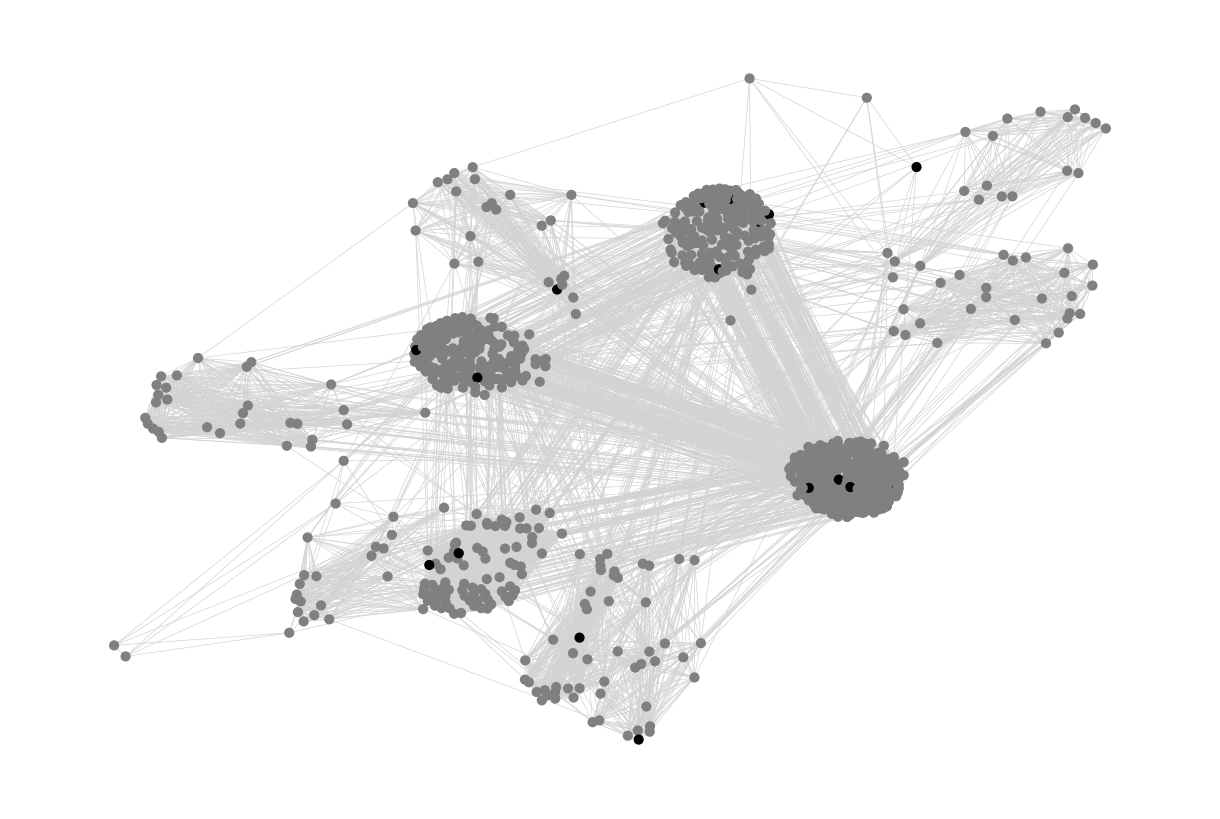

In [ ]:
node_colors = [
    'black' if H_relabel.nodes[n].get('target', 0) == 1 else 'grey'
    for n in H_relabel.nodes()
]

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(H_relabel, seed=42)
nx.draw(
    H_relabel,
    pos,
    node_size=40,
    node_color=node_colors,
    edge_color='lightgray',
    width=0.5,
    with_labels=False
)
#plt.title("Network Plot of H_relabel (target=1 in red)")
plt.show()

In [ ]:
!gdown --id '17wG2Bo0ENVU74Rz5UI2y2jbZc4rfNSHU'

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=17wG2Bo0ENVU74Rz5UI2y2jbZc4rfNSHU
To: /content/areaEdgeList.csv
100% 201k/201k [00:00<00:00, 103MB/s]


In [ ]:
!gdown --id '1Nk_eMZLrkfCmdwHv5OCax2gh52mUZVxw'

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1Nk_eMZLrkfCmdwHv5OCax2gh52mUZVxw
From (redirected): https://drive.google.com/uc?id=1Nk_eMZLrkfCmdwHv5OCax2gh52mUZVxw&confirm=t&uuid=7a0433a0-cafe-4303-9a83-5ad53d151240
To: /content/providerEdgeList.csv
100% 8.79G/8.79G [03:10<00:00, 46.1MB/s]


In [ ]:
area    = pd.read_csv('/content/areaEdgeList.csv')
comp    = pd.read_csv('/content/providerEdgeList.csv')

In [ ]:
edge_df = pd.concat([area, comp], axis = 0)
edge_df.shape

(220474, 2)

In [ ]:
G_areacomp = nx.from_pandas_edgelist(edge_df, source = "source", target = "target")
G_areacomp.number_of_nodes(), G_areacomp.number_of_edges()

(999, 109757)

In [ ]:
for i in tqdm(G_areacomp.nodes()):
    id_loan = merged_df[merged_df['LOAN_NUMBER'] == i]['LOAN_NUMBER'].tolist()[0]
    for f in merged_df.columns[0:23]:


        G_areacomp.nodes[i][f] = merged_df[f][merged_df['LOAN_NUMBER'] == i].tolist()[0]

100%|██████████| 999/999 [01:06<00:00, 14.96it/s]


In [ ]:
mapping = {old_label: new_label for new_label, old_label in enumerate(G_areacomp.nodes())}
H_relabel = nx.relabel_nodes(G_areacomp, mapping)

In [ ]:
with open('network.gpickle', 'wb') as f:
    pickle.dump(H_relabel, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
!gdown 'https://drive.google.com/uc?id=1-AOl7sCEusPqmctnStdPg8Frc9XEOcKf'

Downloading...
From (original): https://drive.google.com/uc?id=1-AOl7sCEusPqmctnStdPg8Frc9XEOcKf
From (redirected): https://drive.google.com/uc?id=1-AOl7sCEusPqmctnStdPg8Frc9XEOcKf&confirm=t&uuid=4c68170f-0458-406a-8269-4ae7c5192d89
To: /content/network.gpickle
100% 307M/307M [00:02<00:00, 144MB/s]


In [ ]:
with open('network.gpickle', 'rb') as f:
    G = pickle.load(f)

In [ ]:
edge_list = nx.to_pandas_edgelist(G)
edge_i = torch.tensor(edge_list.values, dtype=torch.long).t().contiguous()
myData = Data(edge_index=edge_i)

In [ ]:
target_attribute = list(nx.get_node_attributes(G, 'target').values())
myData.y = torch.tensor(target_attribute, dtype=torch.long)

In [ ]:
node_data = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
tmp=node_data.iloc[:,0:21]
myData.x=torch.tensor(tmp.values)

In [ ]:
from torch_geometric.utils import degree

edge_index = myData.edge_index
num_nodes = myData.num_nodes

# Step 1: Compute degree of each node (undirected graph assumed)
deg = degree(edge_index[0], num_nodes=num_nodes)

In [ ]:

# Step 2: Optionally normalize degree (e.g., log scale or min-max)
deg = deg.view(-1, 1)  # Reshape to be a column vector
deg = (deg - deg.min()) / (deg.max() - deg.min())

# Step 3: Concatenate with existing node features
myData.x = torch.cat([myData.x, deg], dim=1)

In [ ]:
myData.x.shape  # Check the shape of the updated node features

torch.Size([49986, 22])

In [ ]:
node_transform = RandomNodeSplit(split='train_rest',num_val=10000, num_test=10000,num_train_per_class=900)
node_splits = node_transform(myData)
node_splits.x = node_splits.x.float()
node_splits.y = node_splits.y.float()

In [ ]:
print()
print(f'Dataset: {node_splits}:')
print('======================')
print(f'Number of features: {node_splits.num_features}')
#print(f'Number of classes: {myData.num_classes}')
print(f'Number of defaults: {(node_splits.y.sum())}')
#===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {node_splits.num_nodes}')
print(f'Number of edges: {node_splits.num_edges}')
print(f'Average node degree: {node_splits.num_edges / node_splits.num_nodes:.2f}')
print(f'Number of training nodes: {node_splits.train_mask.sum()}')
print(f'Number of training nodes: {node_splits.val_mask.sum()}')
print(f'Number of training nodes: {node_splits.test_mask.sum()}')
print(f'Training node label rate: {node_splits.y[node_splits.train_mask].sum() / node_splits.train_mask.sum():.2f}')
print(f'Has isolated nodes: {node_splits.has_isolated_nodes()}')
print(f'Has self-loops: {node_splits.has_self_loops()}')
print(f'Is undirected: {node_splits.is_undirected()}')
#print(f'Node homopily:{homophily(myData.edge_index, myData.y, method='node')}')
#print(f'Edge homopily: {homophily(myData.edge_index, myData.y, method='edge')}')
#print(f'Assortativity:{assortativity(myData.edge_index)}')


Dataset: Data(edge_index=[2, 22588215], y=[49986], x=[49986, 22], train_mask=[49986], val_mask=[49986], test_mask=[49986]):
Number of features: 22
Number of defaults: 1191.0
Number of nodes: 49986
Number of edges: 22588215
Average node degree: 451.89
Number of training nodes: 29986
Number of training nodes: 10000
Number of training nodes: 10000
Training node label rate: 0.02
Has isolated nodes: False
Has self-loops: False
Is undirected: False


In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
node_splits.x = torch.tensor(scaler.fit_transform(node_splits.x.numpy()), dtype=torch.float)

In [ ]:
# ==========================
# Model Definitions
# ==========================

class BinaryGraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels,dense_channels):
        super(BinaryGraphSAGE, self).__init__()
        self.sage1 = SAGEConv(in_channels, hidden_channels)
        #self.bn1 = BatchNorm(hidden_channels)
        self.sage2 = SAGEConv(hidden_channels, hidden_channels)


        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(hidden_channels, dense_channels),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(dense_channels, 1)
        )
    def forward(self, x, edge_index):
        x = self.sage1(x, edge_index)
        #x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.sage2(x, edge_index)
        x=F.relu(x)
        out = self.decoder(x)
        return out.view(-1)

class BinaryGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels,hidden_dense):
        super(BinaryGCN, self).__init__()
        #self.conv1 = GCNConv(in_channels, hidden_channels)
        #self.bn1 = BatchNorm(hidden_channels)
        #self.conv2 = GCNConv(hidden_channels, hidden_channels2)
        #self.Linear
        self.conv1 = GCNConv(in_channels, hidden_channels)
        # Second graph convolutional layer
       # self.conv2 = GCNConv(hidden_channels, hidden_channels)

        # A simple decoder with a ReLU activation
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(hidden_channels, hidden_dense),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(hidden_dense, 1)
        )

    def forward(self, x, edge_index):
 # Pass data through the first GCN layer and apply ReLU activation
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        # Pass data through the second GCN layer and apply ReLU activation
    #    x = self.conv2(x, edge_index)
     #   x = F.relu(x)

        # Pass the node embeddings through the decoder
        out = self.decoder(x)
        return out.view(-1)


class BinaryGAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, dense_channels,heads):
        super(BinaryGAT, self).__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads,concat=False, dropout=0.5)
       # self.bn1 = BatchNorm(hidden_channels * heads)
      #  self.gat2 = GATConv(hidden_channels * heads, hidden_channels, heads=1, concat=False)

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(hidden_channels, dense_channels),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(dense_channels, 1)
        )

    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)
      #  x = self.bn1(x)
        x = F.elu(x)
      #  x = F.dropout(x, p=0.5, training=self.training)
      #  x = self.gat2(x, edge_index)
       # x = F.elu(x)
        out = self.decoder(x)
        return out.view(-1)





In [ ]:
# ==========================
# Training and Evaluation Functions
# ==========================

def train_one_epoch(model, data, optimizer, loss_fn):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask].float())
    loss.backward()
    optimizer.step()
    return loss.item()


@torch.no_grad()
def evaluate(model, data, mask, loss_fn):
    model.eval()
    out = model(data.x, data.edge_index)
    probs = torch.sigmoid(out)
    preds = (probs > 0.5).float()
    y_true = data.y[mask].cpu() # Move to CPU
    y_probs = probs[mask].cpu() # Move to CPU
    y_preds = preds[mask].cpu() # Move to CPU
    #print(y_probs.min())
    #print(y_probs.max())
    acc = accuracy_score(y_true, y_preds)

    try:
        auc = roc_auc_score(y_true, y_probs)
        fpr, tpr, thresholds = roc_curve(y_true, y_probs)

    except ValueError:
        auc = float('nan')

    conf_mat = confusion_matrix(y_true, y_preds)

    val_loss = loss_fn(out[mask], data.y[mask].float()).item()
    return acc, auc, fpr,tpr,y_probs, conf_mat, val_loss


def train_model(model, data, loss_fn, optimizer, patience=20,
                max_epochs=1000, save_path="best_model.pt"):
    best_val_loss = 1e10
    patience_counter = 0
    best_model_state = None
    losses = []
    val_losses = []

    for epoch in range(max_epochs):
        loss = train_one_epoch(model, data, optimizer, loss_fn)
        losses.append(loss)
        _, val_auc,val_fpr,val_tpr,val_y_probs, _, val_loss = evaluate(model, data, data.val_mask, loss_fn)
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
            torch.save(model.state_dict(), save_path)  # Save best model to disk

        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    model.load_state_dict(torch.load(save_path))  # Load best model from disk
    test_acc, test_auc, test_fpr,test_tpr,test_y_probs,conf_mat, _ = evaluate(model, data, data.test_mask, loss_fn)
    return losses, val_losses, test_acc, test_auc, test_fpr,test_tpr,test_y_probs,conf_mat

In [ ]:
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

Training GraphSAGE...


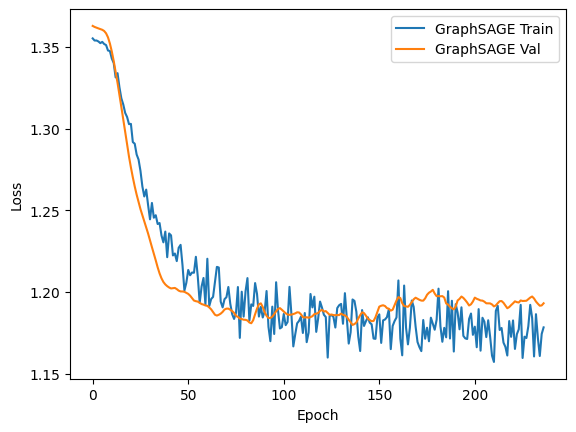

Test Accuracy: 0.7810
Test AUC:      0.7749


<ipython-input-88-3102969233>:63: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="lower right")


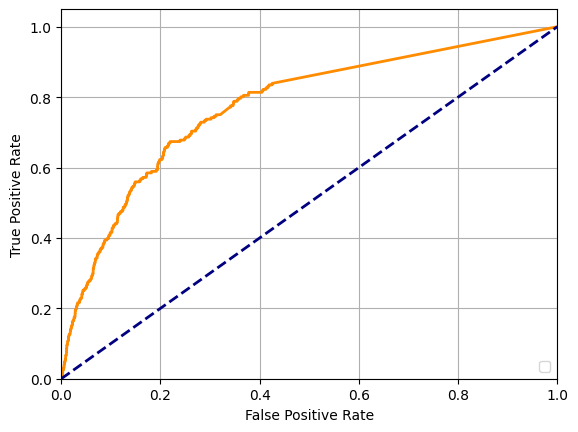

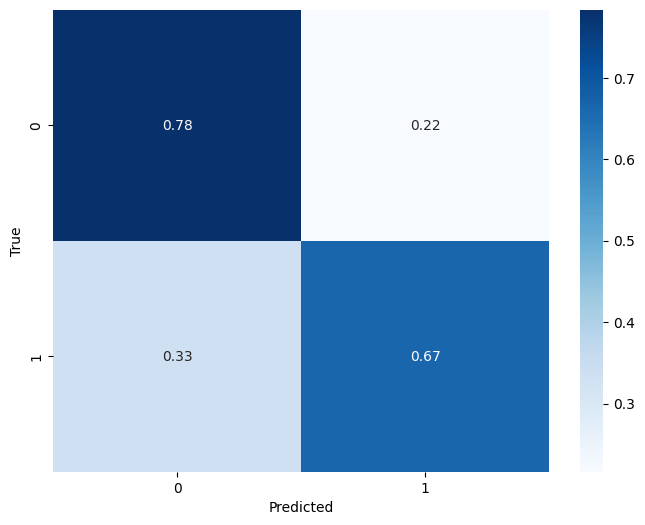

In [ ]:
#0.76
LEARNING_RATE = 0.01
WEIGHT_DECAY = 1e-5
EPOCHS = 1000
PATIENCE = 100
HIDDEN_GNN = 4
HIDDEN_DENSE =4
HEADS=2

# GraphSage: LR 0.01,1000 e, 100 pat, 8, 8.
# GCN: LR 0.0005, 1000 epocs, 100 patience, 1 gcnconv 16, dense 4: AUCH 0.53
# GAT: LR:0.01, 1000 epoch, 100 patence, 1 gatconv 8, do=0.5, 2 heads, dense 4: 0.76

# Empty VRAM
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = node_splits.to(device)

#
y_train = data.y[data.train_mask]
num_pos = (y_train == 1).sum().item()
num_neg = (y_train == 0).sum().item()
pos_weight = torch.tensor([num_neg / num_pos], device=device)
#
models = {
      "GraphSAGE": BinaryGraphSAGE(22, HIDDEN_GNN,HIDDEN_DENSE).to(device),
     #"GCN": BinaryGCN(22, HIDDEN_GNN, HIDDEN_DENSE).to(device),
    # "GAT": BinaryGAT(22, HIDDEN_GNN,HIDDEN_DENSE, HEADS).to(device),

 }
#
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE,
                                 weight_decay=WEIGHT_DECAY)
    loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    losses, val_losses, acc, auc,fpr,tpr,y_probs, cm = train_model(model, data, loss_fn, optimizer,
                                                   patience=PATIENCE, max_epochs=EPOCHS,
                                                   save_path=f"best_{name}.pt")

    results[name] = {"losses": losses, "val_losses": val_losses, "acc": acc, "auc": auc, "fpr": fpr,"tpr":tpr,"y_probs":y_probs,"conf_mat": cm}
    plt.plot(losses, label=f"{name} Train")
    plt.plot(val_losses, label=f"{name} Val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    print(f"Test Accuracy: {acc:.4f}")
    print(f"Test AUC:      {auc:.4f}")

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
   # plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8, 6))
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
 #   plt.title('Confusion Matrix')
    plt.show()



Training GCN...


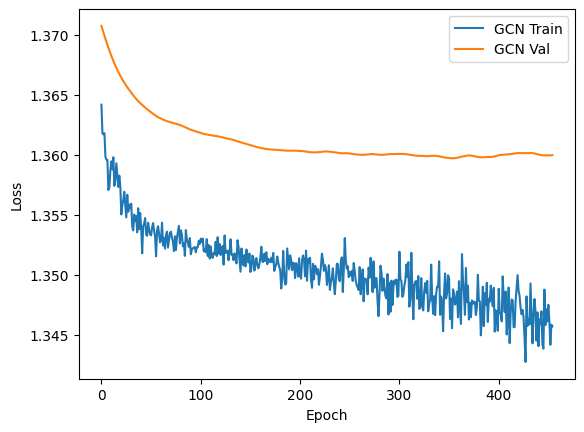

Test Accuracy: 0.5875
Test AUC:      0.5200


<ipython-input-91-4149286195>:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="lower right")


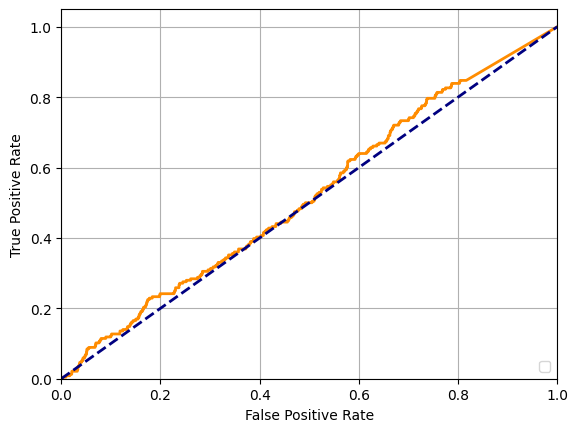

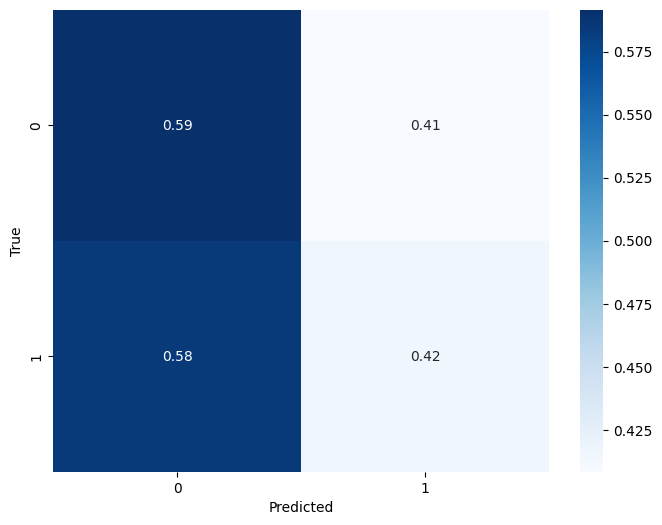

In [ ]:
#0.76
LEARNING_RATE = 0.0005
WEIGHT_DECAY = 1e-4
EPOCHS = 100000
PATIENCE = 100
HIDDEN_GNN = 16
HIDDEN_DENSE =4
HEADS=2


# GCN: LR 0.0005, 1000 epocs, 100 patience, 1 gcnconv 16, dense 4: AUCH 0.53
# GAT: LR:0.01, 1000 epoch, 100 patence, 1 gatconv 8, do=0.5, 2 heads, dense 4: 0.76

# Empty VRAM
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = node_splits.to(device)

#
y_train = data.y[data.train_mask]
num_pos = (y_train == 1).sum().item()
num_neg = (y_train == 0).sum().item()
pos_weight = torch.tensor([num_neg / num_pos], device=device)
#
models = {
     "GCN": BinaryGCN(22, HIDDEN_GNN, HIDDEN_DENSE).to(device),
    # "GAT": BinaryGAT(22, HIDDEN_GNN,HIDDEN_DENSE, HEADS).to(device),
   #  "GraphSAGE": BinaryGraphSAGE(22, HIDDEN_GNN,HIDDEN_DENSE).to(device),
 }
#
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE,
                                 weight_decay=WEIGHT_DECAY)
    loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    losses, val_losses, acc, auc,fpr,tpr,y_probs, cm = train_model(model, data, loss_fn, optimizer,
                                                   patience=PATIENCE, max_epochs=EPOCHS,
                                                   save_path=f"best_{name}.pt")

    results[name] = {"losses": losses, "val_losses": val_losses, "acc": acc, "auc": auc, "fpr": fpr,"tpr":tpr,"y_probs":y_probs,"conf_mat": cm}
    plt.plot(losses, label=f"{name} Train")
    plt.plot(val_losses, label=f"{name} Val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    print(f"Test Accuracy: {acc:.4f}")
    print(f"Test AUC:      {auc:.4f}")

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
  #  plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8, 6))
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
 #   plt.title('Confusion Matrix')
    plt.show()

Training GAT...


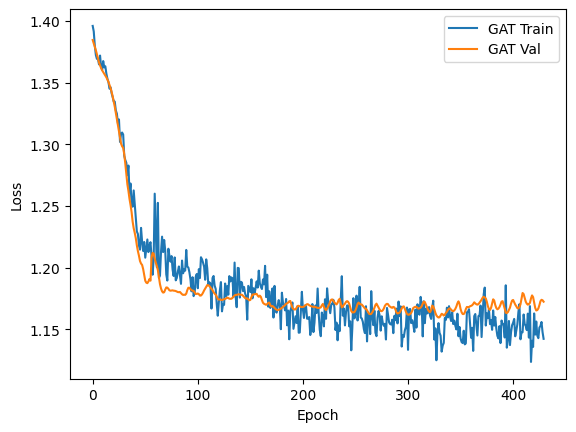

Test Accuracy: 0.6822
Test AUC:      0.7672


<ipython-input-93-1819197530>:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="lower right")


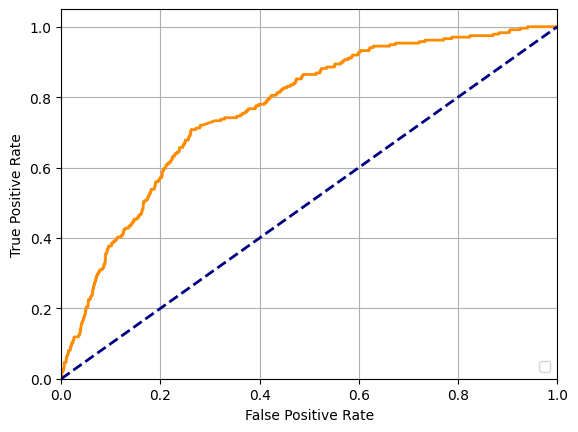

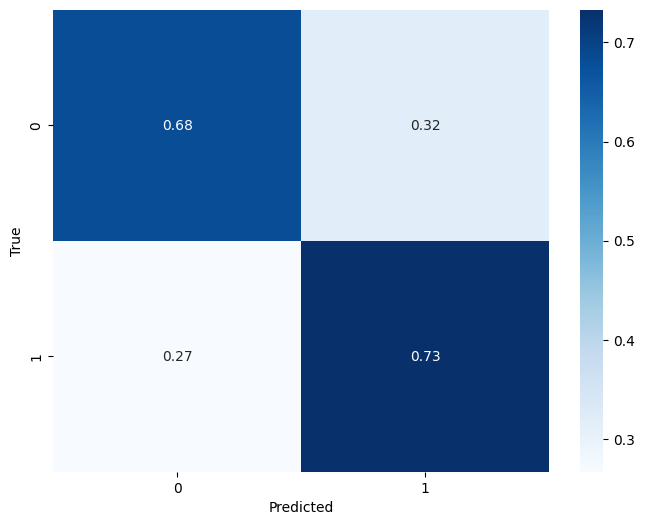

In [ ]:
#0.76
LEARNING_RATE = 0.01
WEIGHT_DECAY = 1e-5
EPOCHS = 1000
PATIENCE = 100
HIDDEN_GNN = 8
HIDDEN_DENSE =4
HEADS=2


# GCN: LR 0.0005, 1000 epocs, 100 patience, 1 gcnconv 16, dense 4: AUCH 0.53
# GAT: LR:0.01, 1000 epoch, 100 patence, 1 gatconv 8, do=0.5, 2 heads, dense 4: 0.76

# Empty VRAM
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = node_splits.to(device)

#
y_train = data.y[data.train_mask]
num_pos = (y_train == 1).sum().item()
num_neg = (y_train == 0).sum().item()
pos_weight = torch.tensor([num_neg / num_pos], device=device)
#
models = {
     #"GCN": BinaryGCN(22, HIDDEN_GNN, HIDDEN_DENSE).to(device),
     "GAT": BinaryGAT(22, HIDDEN_GNN,HIDDEN_DENSE, HEADS).to(device),
   #  "GraphSAGE": BinaryGraphSAGE(22, HIDDEN_GNN,HIDDEN_DENSE).to(device),
 }
#
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE,
                                 weight_decay=WEIGHT_DECAY)
    loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    losses, val_losses, acc, auc,fpr,tpr,y_probs, cm = train_model(model, data, loss_fn, optimizer,
                                                   patience=PATIENCE, max_epochs=EPOCHS,
                                                   save_path=f"best_{name}.pt")

    results[name] = {"losses": losses, "val_losses": val_losses, "acc": acc, "auc": auc, "fpr": fpr,"tpr":tpr,"y_probs":y_probs,"conf_mat": cm}
    plt.plot(losses, label=f"{name} Train")
    plt.plot(val_losses, label=f"{name} Val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    print(f"Test Accuracy: {acc:.4f}")
    print(f"Test AUC:      {auc:.4f}")

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
   # plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8, 6))
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
 #   plt.title('Confusion Matrix')
    plt.show()